In [1]:
import pandas as pd
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import collections
from gensim.models import doc2vec
from sklearn.model_selection import train_test_split
import os
import shutil
import datetime
# from tensorboardX import SummaryWriter
# from gluoncv.utils import TrainingHistory
import warnings
import numpy as np

In [2]:
import os

import tensorflow as tf
from keras import layers
# from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras import backend as K
from keras.models import Model
import keras
from keras_self_attention import SeqSelfAttention
from keras.layers import Lambda,Conv1D, MaxPooling1D,Input, Flatten, Dense,Reshape,Concatenate,LSTM,GlobalAveragePooling1D,Dropout
from keras.backend import slice
from keras.models import Sequential

Using TensorFlow backend.


In [3]:
embedding=np.load('D:/paper/embedding_metrix.npy')

In [4]:
embedding.shape

(62387, 480, 128)

In [12]:
len(data.PERSON_ID.unique())

59792

In [20]:
data=pd.read_csv('D:/all_after_filter.csv')
# mask = data['PERSON_ID'].value_counts()[(data['PERSON_ID'].value_counts()>=4)].index
# alldata = data[data.PERSON_ID.isin(mask)].reset_index(drop=True)
person_id=data['PERSON_ID'].unique()
# alldata.sort_values('RECU_FR_DT',inplace=True)
# alldata.drop(columns=['KEY_SEQ','RECU_FR_DT','MAIN_ICDnorm'],inplace=True)
person_id=person_id.tolist()
train_label_df=pd.read_csv('D:/paper/project/label_train1.csv')
test_label_df=pd.read_csv('D:/paper/project/label_test1.csv')
person_doc_dict={key:value for value,key in enumerate(person_id)}

In [21]:
# train에서 검증셋 추출
from sklearn.model_selection import train_test_split
new_train_label_df, cv_label_df =train_test_split(train_label_df, test_size=0.25, random_state=3)

In [22]:
new_train_label_df.shape ,cv_label_df.shape, test_label_df.shape

((120000, 3), (40000, 3), (40000, 3))

In [23]:
class CSV_dataset():
    def __init__(self, label_df, person_doc_dict, embedding):
        super(CSV_dataset, self).__init__()
        self.label_df = label_df
        self.person_doc_dict = person_doc_dict
        self.embedding = embedding
    def __getitem__(self, item):
        person_1 = self.label_df.iloc[item, 0]
        person_2 = self.label_df.iloc[item, 1]
        person_1_id=self.person_doc_dict[person_1]
        person_2_id=self.person_doc_dict[person_2]
        person_1_vec =self.embedding[person_1_id]
        person_2_vec =self.embedding[person_2_id]
        similarity = self.label_df.iloc[item, 2]
        
        return person_1_vec, person_2_vec, similarity
    def __len__(self):
        return len(self.label_df)

In [24]:
train_ds = CSV_dataset(new_train_label_df, person_doc_dict, embedding)
train_data_left =[]
train_data_right = []
train_label = []

for i in range(10000):
    r = train_ds.__getitem__(i)
    train_data_left.append(r[0])
    train_data_right.append(r[1])
    train_label.append([r[2]])
    
train_data_left = np.array(train_data_left)
train_data_right = np.array(train_data_right)
train_label = np.array(train_label)

In [25]:
cv_ds = CSV_dataset(cv_label_df, person_doc_dict, embedding)
cv_data_left =[]
cv_data_right = []
cv_label = []


for i in range(5000):
    r = cv_ds.__getitem__(i)
    cv_data_left.append(r[0])
    cv_data_right.append(r[1])
    cv_label.append([r[2]])

cv_data_left = np.array(cv_data_left)
cv_data_right = np.array(cv_data_right)
cv_label = np.array(cv_label)


In [26]:
test_ds = CSV_dataset(test_label_df, person_doc_dict, embedding)
test_data_left =[]
test_data_right = []
test_label = []

for i in range(5000):
    r = test_ds.__getitem__(i)
    test_data_left.append(r[0])
    test_data_right.append(r[1])
    test_label.append([r[2]])


test_data_left = np.array(test_data_left)
test_data_right = np.array(test_data_right)
test_label = np.array(test_label)


In [27]:
def difference(vectors):
    (featsA, featsB) = vectors
    return K.abs(featsA-featsB)
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

# 샴네트워크

In [28]:
import tensorflow.keras.backend as K
import tensorflow as tf
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [40]:
from keras import layers
from keras import regularizers
def build_siamese_model(input_shape):
    # specify the inputs for the feature extractor network
    inputs = Input(input_shape)
 
    x = Conv1D(128, 3, padding="same", activation="relu",kernel_regularizer=regularizers.l2(0.0001))(inputs)
    x = MaxPooling1D(pool_size= 2)(x)
    x = Dropout(0.3)(x)
    x = SeqSelfAttention(attention_activation='tanh')(x)  


    x = Conv1D(64, 3, padding="same", activation="relu",kernel_regularizer=regularizers.l2(0.0001))(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = SeqSelfAttention(attention_activation='tanh')(x)
    
    x = Conv1D(32, 3, padding="same", activation="relu",kernel_regularizer=regularizers.l2(0.0001))(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = SeqSelfAttention(attention_activation='tanh')(x)
    model = Model(inputs, x)
    return model

In [41]:
model = build_siamese_model((480,128))

In [42]:
input_a =Input(shape=(480,128))
process_a = model(input_a)
input_b =Input(shape=(480,128))
process_b = model(input_b)

p1 = Flatten()(process_a)
p2 = Flatten()(process_b)
distance =Lambda(euclidean_distance)([p1,p2]) 
outputs1 = layers.Dense(1, activation='sigmoid',name='dense_1')(distance)
model =  Model(inputs=[input_a,input_b], outputs=outputs1)
model.compile(loss=contrastive_loss,optimizer='adam')
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 480, 128)     0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 480, 128)     0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 60, 32)       94627       input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 1920)         0           model_5[1][0]              

In [43]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

In [44]:
es = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=3, restore_best_weights=True)
history =  model.fit([train_data_left, train_data_right], [train_label],validation_data=([cv_data_left, cv_data_right], [cv_label]), 
                                                                                  batch_size=128, epochs=100, callbacks=[es])

Train on 10000 samples, validate on 5000 samples
Epoch 1/100
10000/10000 [==============================] - 417s 42ms/step - loss: 0.2759 - val_loss: 0.2709
Epoch 2/100
10000/10000 [==============================] - 414s 41ms/step - loss: 0.2686 - val_loss: 0.2663
Epoch 3/100
10000/10000 [==============================] - 416s 42ms/step - loss: 0.2644 - val_loss: 0.2627
Epoch 4/100
10000/10000 [==============================] - 414s 41ms/step - loss: 0.2610 - val_loss: 0.2602
Epoch 5/100
10000/10000 [==============================] - 408s 41ms/step - loss: 0.2583 - val_loss: 0.2584
Epoch 6/100
10000/10000 [==============================] - 405s 41ms/step - loss: 0.2558 - val_loss: 0.2575
Epoch 7/100
10000/10000 [==============================] - 408s 41ms/step - loss: 0.2545 - val_loss: 0.2565
Epoch 8/100
10000/10000 [==============================] - 405s 40ms/step - loss: 0.2526 - val_loss: 0.2556
Epoch 9/100
10000/10000 [==============================] - 411s 41ms/step - loss: 0.251

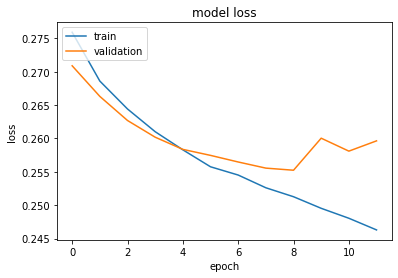

In [45]:
from matplotlib import pyplot as plt
## 질병만
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
pred = model.predict([test_data_left,test_data_right])

In [51]:
min(pred),max(pred)

(array([0.46850997], dtype=float32), array([0.8993498], dtype=float32))

In [52]:
model.save('D:/paper/project/siamese.h5')

In [57]:
from keras.models import load_model
m = load_model('D:/paper/project/siamese.h5',custom_objects={'SeqSelfAttention':SeqSelfAttention,
                                                                                     'contrastive_loss':contrastive_loss})